# Processing corrected samples

Datasets typically consist of several wells on a microscopy slide. In this notebook, the wells are integrated to one annotated data matrix.

In [13]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import multiprocessing
from joblib import Parallel, delayed
from importlib import reload
from tqdm import tqdm
import statsmodels.formula.api as smf
import seaborn as sns
import sys
sys.path.append('/home/mklein/spacem')
sys.path.append('/home/mklein/FDA_project')
from src.correction import get_matrices_from_dfs, normalize_proportion_ratios
from src import const
from src.evaluation import plot_all_ion_slopes

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [14]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'
    
# this is the column of the annotated data matrix, that discriminates between conditions
condition_name = 'dataset_3'

In [26]:
samples = [dir.name for dir in os.scandir(target_path) if dir.is_dir() and dir.name[0] != "."]

files = {
        'am_sm_matrix': 'am_spatiomolecular_adata.h5ad',
        'corr_am_sm_matrix': 'am_spatiomolecular_adata_corrected.h5ad',
        'cell_sm_matrix': 'cells_spatiomolecular_adata_spacem.h5ad',
        'gen_cell_sm_matrix': 'cells_spatiomolecular_adata.h5ad',
        'corr_cell_sm_matrix': 'cells_spatiomolecular_adata_corrected.h5ad',
    }


After loading all individual wells, they are concatenated into one data matrix. Cell identifiers are kept unique by adding a well-specific suffix 

In [27]:
am_adata_dict = {}
am_adata_cor_dict = {}
adata_dict = {}
gen_adata_dict = {}
adata_cor_dict = {}

for sample in tqdm(samples):
    sample_path = os.path.join(target_path, sample)

    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    # am_adata_dict[sample] = sc.read(project_files['am_sm_matrix'])
    # am_adata_cor_dict[sample] = sc.read(project_files['corr_am_sm_matrix'])
    adata_dict[sample] = sc.read(project_files['cell_sm_matrix'])
    gen_adata_dict[sample] = sc.read(project_files['gen_cell_sm_matrix'])
    adata_cor_dict[sample] = sc.read(project_files['corr_cell_sm_matrix'])


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


In [20]:
def split_dataset_info(adata):
    split = adata.obs['dataset'].str.split("_", expand=True)
    adata.obs[['dataset_' + str(col) for col in split.columns]] = split

In [32]:
import functools
def concat_wells(adata_dict):
    adata = ad.concat(adata_dict, label='well', index_unique="_", merge="first", join='inner', fill_value=0)
    
    conca_var_df = pd.concat({k: v.var for k, v in adata_dict.items()}).select_dtypes(include=[float])
    if 'correction_quantreg_slope' in conca_var_df.columns:

        mean_var_df = conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').mean(numeric_only = True)
        mean_var_df.columns = ['mean_'+col for col in mean_var_df.columns]
        
        std_var_df = conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').std(numeric_only = True)
        std_var_df.columns = ['sd_'+col for col in std_var_df.columns]
        
        dfs = [adata.var, 
            mean_var_df[['mean_correction_full_pixel_avg_intensities', 'mean_correction_quantreg_slope', 'mean_correction_quantreg_intersect']], 
            std_var_df[['sd_correction_full_pixel_avg_intensities', 'sd_correction_quantreg_slope', 'sd_correction_quantreg_intersect']] ]
        
        adata.var = functools.reduce(lambda left,right: pd.merge(left, right, how='left', left_index=True, right_index=True), dfs)
    
    #sc.tl.pca(adata)
    #sc.external.pp.bbknn(adata, batch_key='well')
    split_dataset_info(adata)
    return adata

# am_adata = concat_wells(am_adata_dict)
# am_adata_cor = concat_wells(am_adata_cor_dict)
adata = concat_wells(adata_dict)
gen_adata = concat_wells(gen_adata_dict)
adata_cor = concat_wells(adata_cor_dict)

The combined data matrix contains cells of the following conditions:

In [34]:
adata.write(os.path.join(target_path, "batch_sm_matrix.h5ad"))
gen_adata.write(os.path.join(target_path, "gen_batch_sm_matrix.h5ad"))
adata_cor.write(os.path.join(target_path, "corrected_batch_sm_matrix.h5ad"))

Across conditions and wells, the ion suppression correction should not have varying influences on the ion intensities. Using the included positional and size information of the cell-based data matrices, one can observe potential dependencies in the data.

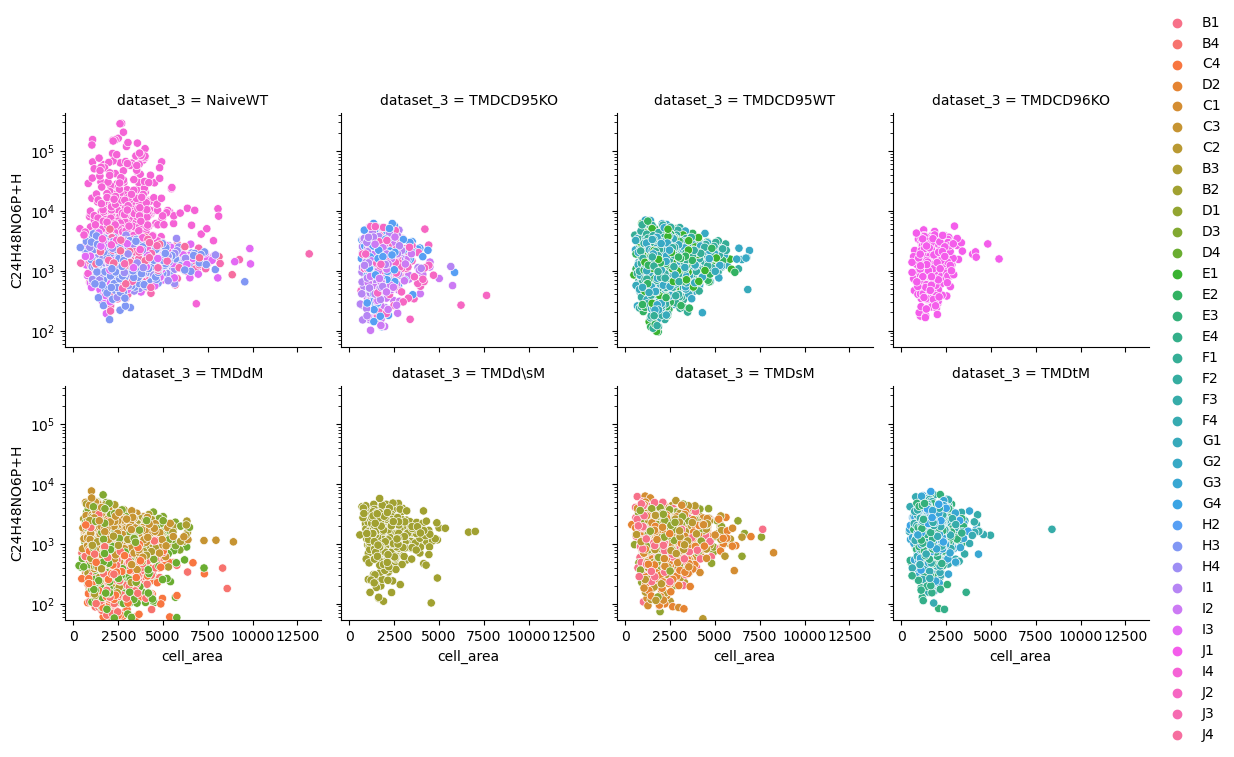

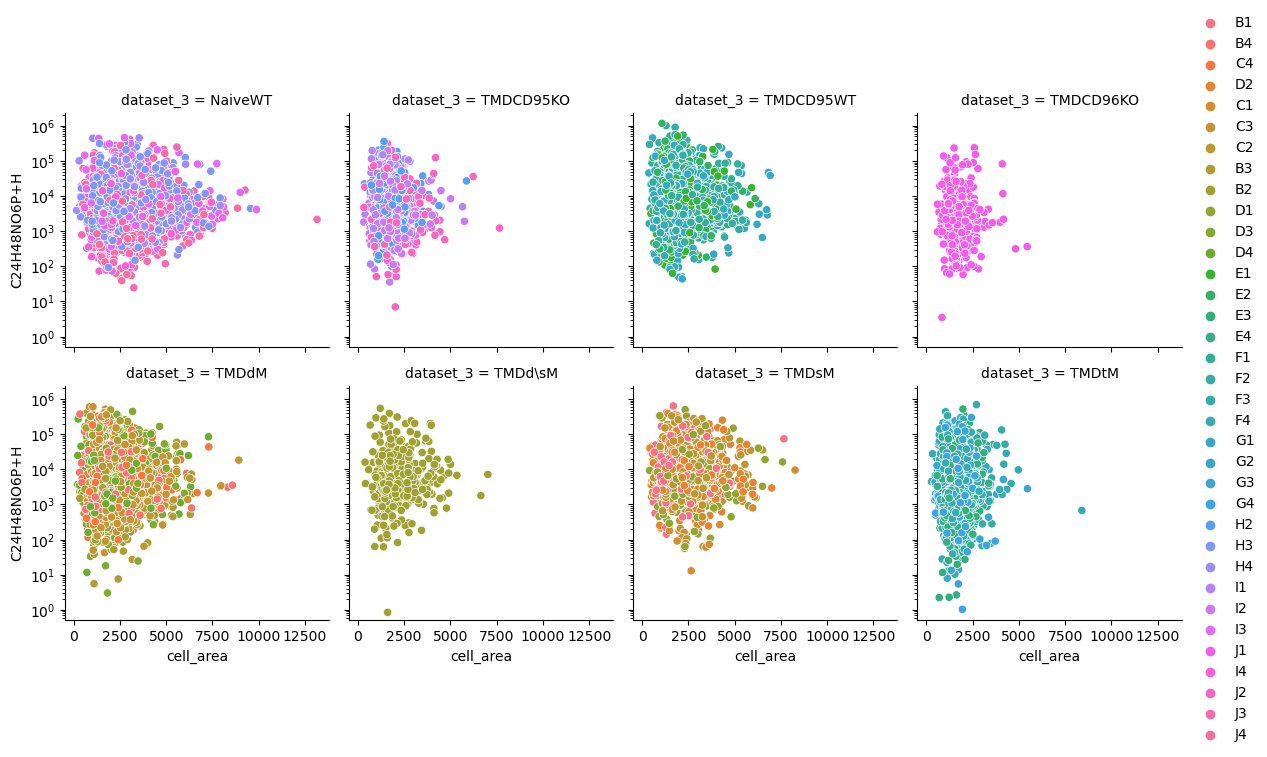

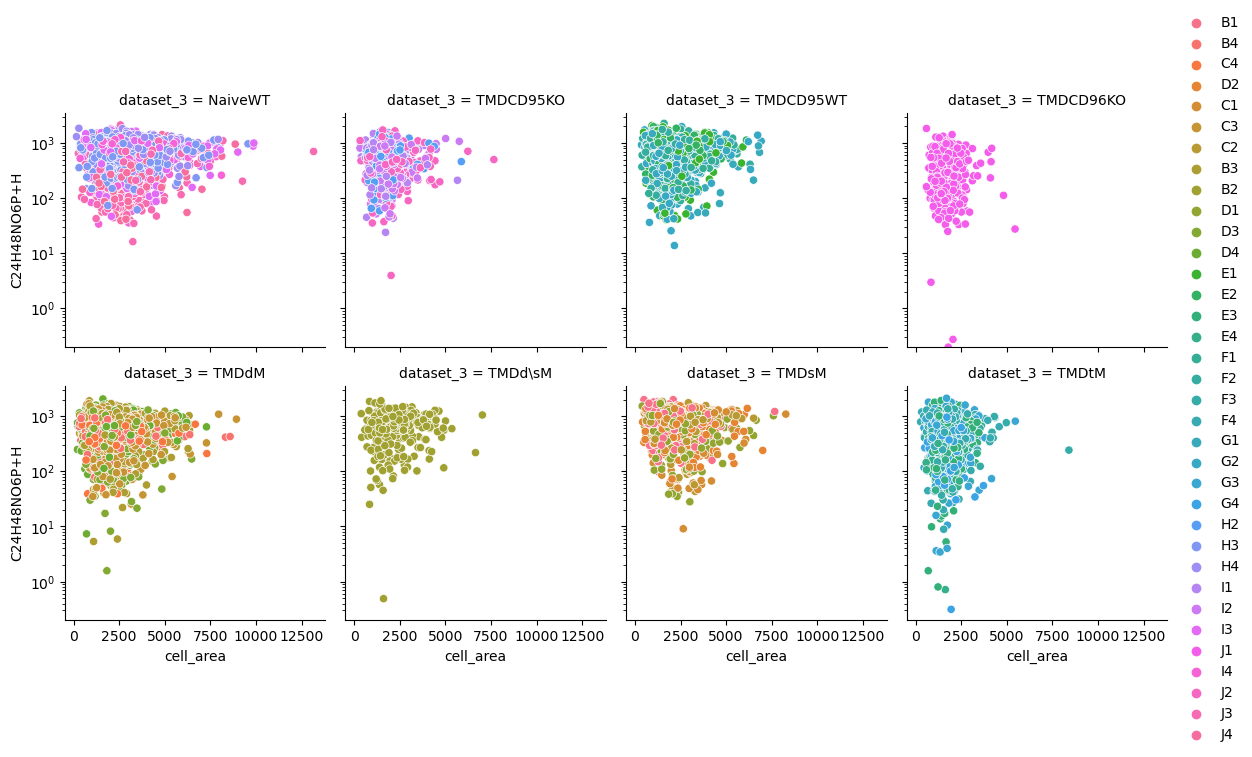

In [10]:
import warnings
warnings.filterwarnings('ignore')

def plot_by(adata, ion = 'C24H48NO6P+H', col = "dataset_3", x = 'cell_area', color = 'well'):
    plot_df = sc.get.obs_df(adata, keys=[col, ion, x, color])
    #plot_df = plot_df[plot_df[ion] > 0]
    graph = sns.FacetGrid(plot_df, col=col, col_wrap=4)
    graph.map(sns.scatterplot, x, ion, hue=plot_df[color]).add_legend().set(yscale='log')
                                         
plot_by(adata)
plot_by(gen_adata)
plot_by(adata_cor)

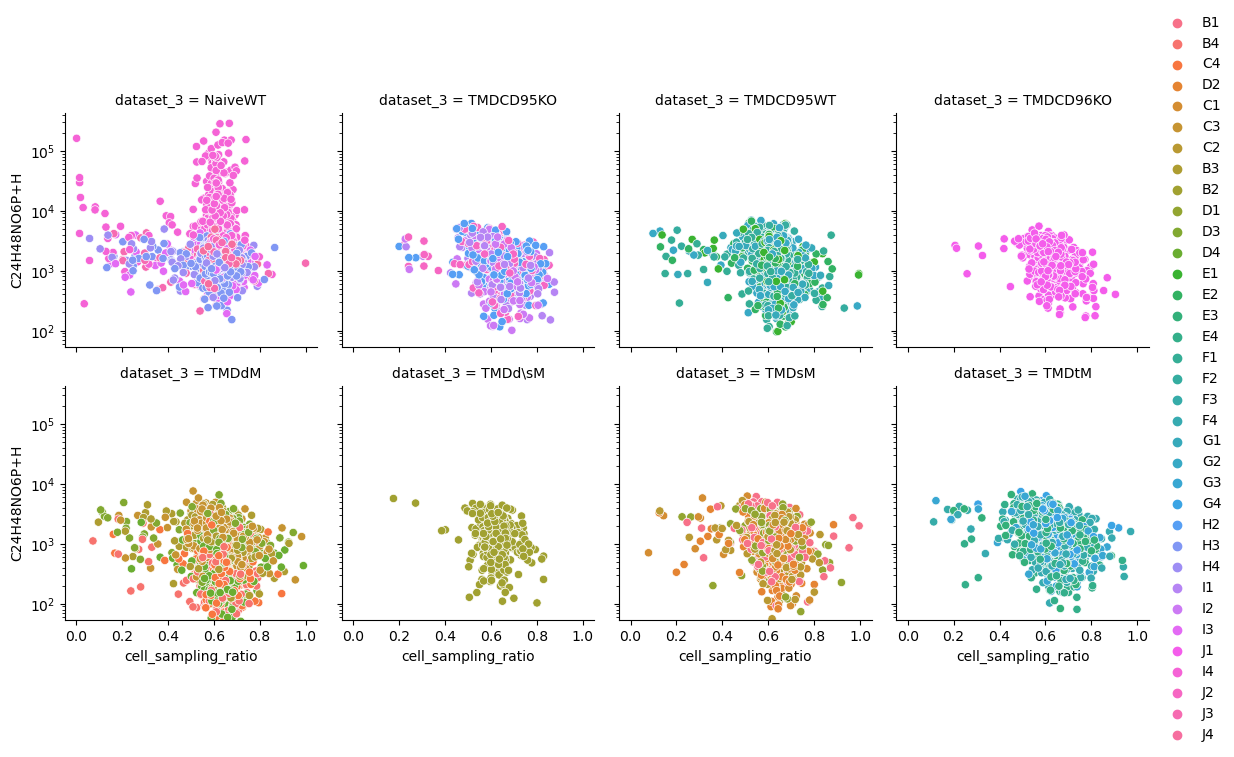

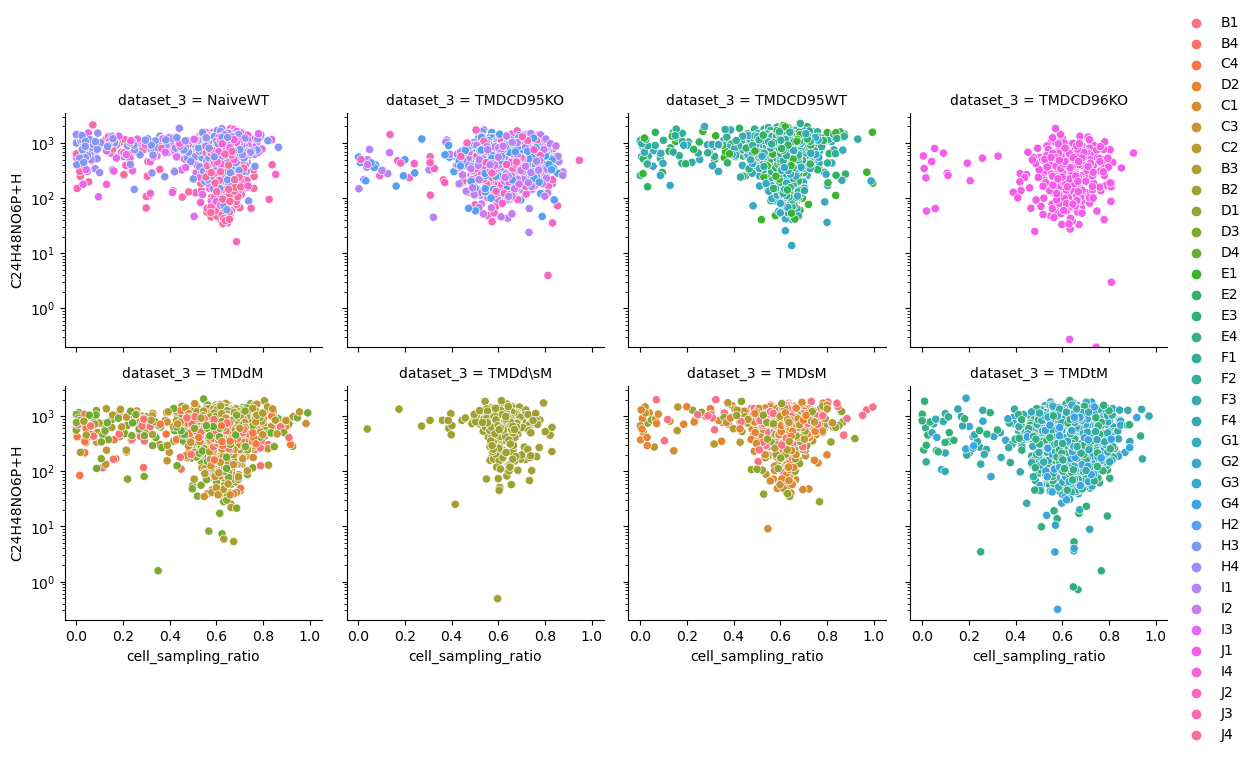

In [11]:
plot_by(adata, x = 'cell_sampling_ratio')
plot_by(adata_cor, x = 'cell_sampling_ratio')